# Dask-GeoPandas Sorted

In [1]:
import time
from datetime import datetime
from pathlib import Path

import geopandas
import dask_geopandas

import dask.dataframe as dd
from distributed import LocalCluster, Client

In [2]:
# set up data paths
base_path = Path().cwd().parent.parent
data_dir = base_path.joinpath('data')

In [3]:
# create local dask cluster
cluster = LocalCluster(#silence_logs=logging.ERROR,
                       dashboard_address=':8790',
                       n_workers=1,
                       threads_per_worker=4,
                       memory_limit='8 GB')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8790/status,
Dashboard: http://127.0.0.1:8790/status,Workers: 1
Total threads: 4,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35549,Workers: 1
Dashboard: http://127.0.0.1:8790/status,Total threads: 4
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://192.168.0.118:41261,Total threads: 4
Dashboard: http://192.168.0.118:36409/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:46467,


In [4]:
# load spatially sorted us data
spatial_sort_path = data_dir.joinpath('us_cont_spatiallysorted_geopandas.parquet')
df = dask_geopandas.read_parquet(spatial_sort_path)
df

,latitude,longitude,geometry
npartitions=1218,,,
25629,float64,float64,geometry
51981109,...,...,...
...,...,...,...
1027558833,...,...,...
1073720176,...,...,...


In [5]:
df.head(2)

,latitude,longitude,geometry
hilbert_distance,,,
25629,24.447,-124.443,POINT (-124.44300 24.44700)
99850,24.704,-124.532,POINT (-124.53200 24.70400)


In [6]:
len_df = len(df)
len_df

113944489

<AxesSubplot:>

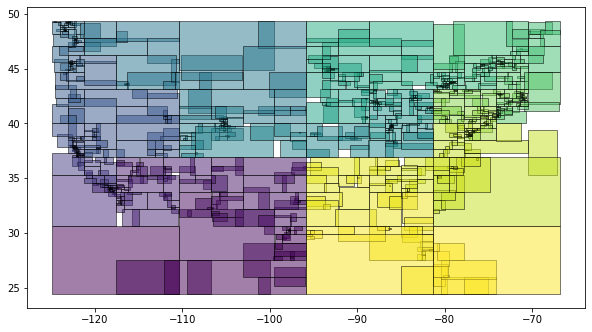

In [7]:
df.spatial_partitions.plot(cmap="viridis", alpha=0.5, edgecolor="k", figsize=(10, 6))

## Joining with a geopandas.GeoDataFrame

Thus, not making use of spatial extent information of the polygon layer

In [8]:
# load various size subsets of the zip code data as geopandas.GeoDataFrames
zips_1 = geopandas.read_file(data_dir.joinpath('zip_codes', 'zips_1.geojson')).loc[:, ['geometry']]
zips_10 = geopandas.read_file(data_dir.joinpath('zip_codes', 'zips_10.geojson')).loc[:, ['geometry']]
zips_100 = geopandas.read_file(data_dir.joinpath('zip_codes', 'zips_100.geojson')).loc[:, ['geometry']]
zips_1000 = geopandas.read_file(data_dir.joinpath('zip_codes', 'zips_1000.geojson')).loc[:, ['geometry']]
zips_10000 = geopandas.read_file(data_dir.joinpath('zip_codes', 'zips_10000.geojson')).loc[:, ['geometry']]

In [9]:
%%time
total_points = len_df
num_partitions = df.npartitions
num_polygons = []
time_sec = []
num_result_points = []
num_result_partitions = []
num_points = len_df

t00 = time.time()
for zip_gdf in [zips_1, zips_10, zips_100, zips_1000, zips_10000]:
    num_polygons.append(len(zip_gdf))
    t0 = time.time()
    
    rdf = dask_geopandas.sjoin(df, zip_gdf, how='inner', op="within")
    # calculate lenght as cheap operation to avoid computing the full resulting frame into memory
    len_result = len(rdf)
    
    time_sec.append(time.time() - t0)
    num_result_points.append(len_result)
    num_result_partitions.append(rdf.npartitions)
    print(f'num_polygons[-1]: {num_polygons[-1]}, time_sec[-1]: {time_sec[-1]:.0f} s')

distributed.utils - ERROR - 'disk-write-read-parquet'
Traceback (most recent call last):
  File "/home/joris/miniconda3/envs/geo/lib/python3.9/site-packages/distributed/utils.py", line 645, in log_errors
    yield
  File "/home/joris/miniconda3/envs/geo/lib/python3.9/site-packages/distributed/dashboard/components/shared.py", line 285, in update
    ts = metadata["keys"][self.key]
KeyError: 'disk-write-read-parquet'
tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f0d682a9c70>>, <Task finished name='Task-23280' coro=<_needs_document_lock.<locals>._needs_document_lock_wrapper() done, defined at /home/joris/miniconda3/envs/geo/lib/python3.9/site-packages/bokeh/server/session.py:51> exception=KeyError('disk-write-read-parquet')>)
Traceback (most recent call last):
  File "/home/joris/miniconda3/envs/geo/lib/python3.9/site-packages/tornado/ioloop.py", line 741, in _run_callback
 

num_polygons[-1]: 1, time_sec[-1]: 212 s
num_polygons[-1]: 10, time_sec[-1]: 208 s
num_polygons[-1]: 100, time_sec[-1]: 209 s
num_polygons[-1]: 1000, time_sec[-1]: 214 s
num_polygons[-1]: 10000, time_sec[-1]: 237 s
CPU times: user 1min 52s, sys: 10.4 s, total: 2min 3s
Wall time: 18min


In [10]:
# save summary info to file
results_df = pd.DataFrame({'num_polygons': num_polygons,
                           'num_points': num_points,
                           'num_result_partitions': num_result_partitions,
                           'num_result_points': num_result_points,
                           'time_min': np.asarray(time_sec)/60})                      
results_df.to_csv(f'spatially_sorted_geopandas_results_{datetime.now()}.csv')
results_df

,num_polygons,num_points,num_result_partitions,num_result_points,time_min
0,1,113944489,1218,1031,3.537312
1,10,113944489,1218,6551,3.459357
2,100,113944489,1218,203284,3.486922
3,1000,113944489,1218,2403824,3.567107
4,10000,113944489,1218,25877947,3.952623


Below is the initial result without using `op="within"`:

In [12]:
# save summary info to file
results_df = pd.DataFrame({'num_polygons': num_polygons,
                           'num_points': num_points,
                           'num_result_partitions': num_result_partitions,
                           'num_result_points': num_result_points,
                           'time_min': np.asarray(time_sec)/60})                      
results_df.to_csv(f'spatially_sorted_geopandas_results_{datetime.now()}.csv')
results_df

,num_polygons,num_points,num_result_partitions,num_result_points,time_min
0,1,113944489,1218,1031,3.034132
1,10,113944489,1218,6551,3.129782
2,100,113944489,1218,203284,2.835508
3,1000,113944489,1218,2403824,3.293911
4,10000,113944489,1218,25877947,9.147594


## Joining with a dask_geopandas.GeoDataFrame with default spatial partitions


When passing a geopandas.GeoDataFrame (above), the `sjoin` will not calculate the spatial extent of the polygons layer. Therefore, here doing the conversion to a single-partitions dask_geopandas.GeoDataFrame manually, to ensure it has a known spatial extent:

In [9]:
zips_1b = dask_geopandas.from_geopandas(zips_1, npartitions=1)
zips_1b.calculate_spatial_partitions()
zips_10b = dask_geopandas.from_geopandas(zips_10, npartitions=1)
zips_10b.calculate_spatial_partitions()
zips_100b = dask_geopandas.from_geopandas(zips_100, npartitions=1)
zips_100b.calculate_spatial_partitions()
zips_1000b = dask_geopandas.from_geopandas(zips_1000, npartitions=1)
zips_1000b.calculate_spatial_partitions()
zips_10000b = dask_geopandas.from_geopandas(zips_10000, npartitions=1)
zips_10000b.calculate_spatial_partitions()

In [10]:
%%time
total_points = len_df
num_partitions = df.npartitions
num_polygons = []
time_sec = []
num_result_points = []
num_result_partitions = []
num_points = len_df

t00 = time.time()
for zip_gdf in [zips_1b, zips_10b, zips_100b, zips_1000b, zips_10000b]:
    num_polygons.append(len(zip_gdf))
    t0 = time.time()
    
    rdf = dask_geopandas.sjoin(df, zip_gdf, how='inner', op="within")
    # calculate lenght as cheap operation to avoid computing the full resulting frame into memory
    len_result = len(rdf)
    
    time_sec.append(time.time() - t0)
    num_result_points.append(len_result)
    num_result_partitions.append(rdf.npartitions)
    print(f'num_polygons[-1]: {num_polygons[-1]}, time_sec[-1]: {time_sec[-1]:.0f} s')

num_polygons[-1]: 1, time_sec[-1]: 1 s
num_polygons[-1]: 10, time_sec[-1]: 107 s
num_polygons[-1]: 100, time_sec[-1]: 181 s
num_polygons[-1]: 1000, time_sec[-1]: 226 s
num_polygons[-1]: 10000, time_sec[-1]: 268 s
CPU times: user 1min 35s, sys: 7.79 s, total: 1min 42s
Wall time: 13min 6s


In [11]:
# save summary info to file
results_df = pd.DataFrame({'num_polygons': num_polygons,
                           'num_points': num_points,
                           'num_result_partitions': num_result_partitions,
                           'num_result_points': num_result_points,
                           'time_min': np.asarray(time_sec)/60})                      
results_df.to_csv(f'spatially_sorted_dask-geopandas_default-spatial_results_{datetime.now()}.csv')
results_df

,num_polygons,num_points,num_result_partitions,num_result_points,time_min
0,1,113944489,3,1031,0.009912
1,10,113944489,607,6551,1.786277
2,100,113944489,994,203284,3.021713
3,1000,113944489,1165,2403824,3.771723
4,10000,113944489,1186,25877947,4.465346


Below is the initial result without using `op="within"`:

In [18]:
# save summary info to file
results_df = pd.DataFrame({'num_polygons': num_polygons,
                           'num_points': num_points,
                           'num_result_partitions': num_result_partitions,
                           'num_result_points': num_result_points,
                           'time_min': np.asarray(time_sec)/60})                      
results_df.to_csv(f'spatially_sorted_dask-geopandas_default-spatial_results_{datetime.now()}.csv')
results_df

,num_polygons,num_points,num_result_partitions,num_result_points,time_min
0,1,113944489,3,1031,0.009443
1,10,113944489,607,6551,1.338310
2,100,113944489,994,203284,2.292774
3,1000,113944489,1165,2403824,3.254625
4,10000,113944489,1186,25877947,9.413059


However, the default (convex hull) spatial partitions are not helping much (they quickly cover the full of the US, except for the first case of a single polygon).

## Joining with a dask_geopandas.GeoDataFrame with detailed spatial partitions

To overcome this issue of broad spatial partitions, we can make them more detailed by manually calculating them as the unary_union of the polygons (without taking a final convex hull). This is also closer to what `spatialpandas` does under the hood in the spatial join:

In [8]:
zips_1b.spatial_partitions = geopandas.GeoSeries([zips_1b.envelope.unary_union.compute()], crs=df.crs)
zips_10b.spatial_partitions = geopandas.GeoSeries([zips_10b.envelope.unary_union.compute()], crs=df.crs)
zips_100b.spatial_partitions = geopandas.GeoSeries([zips_100b.envelope.unary_union.compute()], crs=df.crs)
zips_1000b.spatial_partitions = geopandas.GeoSeries([zips_1000b.envelope.unary_union.compute()], crs=df.crs)
zips_10000b.spatial_partitions = geopandas.GeoSeries([zips_10000b.envelope.unary_union.compute()], crs=df.crs)

In [11]:
%%time
total_points = len_df
num_partitions = df.npartitions
num_polygons = []
time_sec = []
num_result_points = []
num_result_partitions = []
num_points = len_df

t00 = time.time()
for zip_gdf in [zips_1b, zips_10b, zips_100b, zips_1000b, zips_10000b]:
    num_polygons.append(len(zip_gdf))
    t0 = time.time()
    
    rdf = dask_geopandas.sjoin(df, zip_gdf, how='inner', op="within")
    # calculate lenght as cheap operation to avoid computing the full resulting frame into memory
    len_result = len(rdf)
    
    time_sec.append(time.time() - t0)
    num_result_points.append(len_result)
    num_result_partitions.append(rdf.npartitions)
    print(f'num_polygons[-1]: {num_polygons[-1]}, time_sec[-1]: {time_sec[-1]:.0f} s')

/home/joris/scipy/repos/dask-geopandas/dask_geopandas/sjoin.py:55: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  parts = geopandas.sjoin(


num_polygons[-1]: 1, time_sec[-1]: 1 s


/home/joris/scipy/repos/dask-geopandas/dask_geopandas/sjoin.py:55: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  parts = geopandas.sjoin(


num_polygons[-1]: 10, time_sec[-1]: 3 s


/home/joris/scipy/repos/dask-geopandas/dask_geopandas/sjoin.py:55: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  parts = geopandas.sjoin(


num_polygons[-1]: 100, time_sec[-1]: 30 s


/home/joris/scipy/repos/dask-geopandas/dask_geopandas/sjoin.py:55: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  parts = geopandas.sjoin(


num_polygons[-1]: 1000, time_sec[-1]: 112 s


/home/joris/scipy/repos/dask-geopandas/dask_geopandas/sjoin.py:55: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  parts = geopandas.sjoin(


num_polygons[-1]: 10000, time_sec[-1]: 204 s
CPU times: user 40.6 s, sys: 3.16 s, total: 43.7 s
Wall time: 5min 53s


In [12]:
# save summary info to file
results_df = pd.DataFrame({'num_polygons': num_polygons,
                           'num_points': num_points,
                           'num_result_partitions': num_result_partitions,
                           'num_result_points': num_result_points,
                           'time_min': np.asarray(time_sec)/60})                      
results_df.to_csv(f'spatially_sorted_dask-geopandas_detailed-spatial_results_{datetime.now()}.csv')
results_df

,num_polygons,num_points,num_result_partitions,num_result_points,time_min
0,1,113944489,3,1031,0.010512
1,10,113944489,21,6551,0.056898
2,100,113944489,179,203284,0.507266
3,1000,113944489,648,2403824,1.862764
4,10000,113944489,1035,25877947,3.406320


Below is the initial result without using `op="within"`:

In [21]:
# save summary info to file
results_df = pd.DataFrame({'num_polygons': num_polygons,
                           'num_points': num_points,
                           'num_result_partitions': num_result_partitions,
                           'num_result_points': num_result_points,
                           'time_min': np.asarray(time_sec)/60})                      
results_df.to_csv(f'spatially_sorted_dask-geopandas_detailed-spatial_results_{datetime.now()}.csv')
results_df

,num_polygons,num_points,num_result_partitions,num_result_points,time_min
0,1,113944489,3,1031,0.008863
1,10,113944489,21,6551,0.050905
2,100,113944489,179,203284,0.469834
3,1000,113944489,648,2403824,1.984690
4,10000,113944489,1035,25877947,8.973437


## Joining with a partitioned / spatially sorted GeoDataFrame

Up to now, the zips polygon GeoDataFrame always consisted of a single partition. Can we improve it further by (spatially) partitioning it as well?

In [8]:
zips_10000 = geopandas.read_parquet(data_dir.joinpath('zip_codes', 'zips_10000.parquet')).loc[:, ['geometry']]

In [9]:
zips_10000c = dask_geopandas.from_geopandas(zips_10000, npartitions=10)

In [10]:
zips_10000c_shuffled = zips_10000c.set_index(zips_10000c.geometry.hilbert_distance(), compute=True)

why is this persist needed? (I already did `compute=True` above?)

In [11]:
zips_10000c_shuffled = zips_10000c_shuffled.persist()

In [12]:
zips_10000c_shuffled.calculate_spatial_partitions()

<AxesSubplot:>

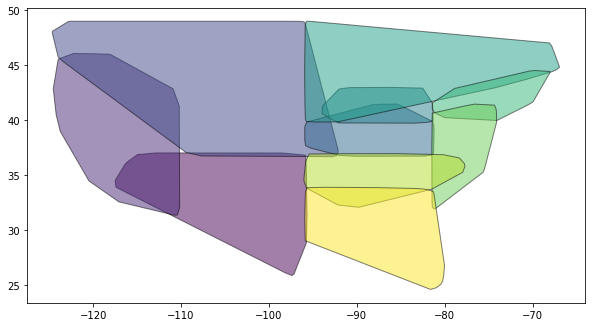

In [13]:
zips_10000c_shuffled.spatial_partitions.plot(cmap="viridis", alpha=0.5, edgecolor="k", figsize=(10, 6))

In [17]:
rdf = dask_geopandas.sjoin(df, zips_10000c_shuffled, how='inner', op="within")

/home/joris/miniconda3/envs/geo/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3427: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
rdf

,latitude,longitude,geometry,index_right
npartitions=1609,,,,
,float64,float64,geometry,int64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [20]:
%%time
len(rdf)

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker


With the full points dataset this runs into memory issues (I interupted the process above, because it started to run very slow / spill data to dask). From looking at the task stream, it seems that in this case it is loading too many of the point partitions into memory upfront, exploding memory (in "theory", it should only load 4 partitions in memory, given that there are 4 threads that then can do a spatial join with it, but while the computation is running, the number of in-memory "read-parquet" tasks continuously increases, and at 60 it starts to spill to disk and run slow, and at 90 I interupted the process).

Testing with a subset of the points layer below:

In [14]:
from dask.distributed import performance_report

In [15]:
df2 = df.partitions[:100]
df2.spatial_partitions = df.spatial_partitions[:100]

With single-partition geopandas GeoDataFrame:

In [18]:
rdf = dask_geopandas.sjoin(df2, zips_10000, how="inner", op="within")

/home/joris/miniconda3/envs/geo/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3427: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
rdf

,latitude,longitude,geometry,index_right
npartitions=100,,,,
,float64,float64,geometry,int64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [20]:
%%time
with performance_report(filename="dask-report-1.html"):
    print(len(rdf))

2114451
CPU times: user 2.18 s, sys: 333 ms, total: 2.52 s
Wall time: 19.7 s


With the spatially partitioned GeoDataFrame:

In [21]:
rdf2 = dask_geopandas.sjoin(df2, zips_10000c_shuffled, how='inner', op="within")

/home/joris/miniconda3/envs/geo/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3427: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [22]:
rdf2

,latitude,longitude,geometry,index_right
npartitions=131,,,,
,float64,float64,geometry,int64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [23]:
%%time
with performance_report(filename="dask-report-2.html"):
    print(len(rdf2))

2114451
CPU times: user 1.08 s, sys: 80.1 ms, total: 1.16 s
Wall time: 17.2 s


In [ ]:
%%time
total_points = len_df
num_partitions = df.npartitions
num_polygons = []
time_sec = []
num_result_points = []
num_result_partitions = []
num_points = len_df

t00 = time.time()
for zip_gdf in [zips_10000c_shuffled]:
    num_polygons.append(len(zip_gdf))
    t0 = time.time()
    
    rdf = dask_geopandas.sjoin(df.partitions[:500], zip_gdf, how='inner')
    # calculate lenght as cheap operation to avoid computing the full resulting frame into memory
    len_result = len(rdf)
    
    time_sec.append(time.time() - t0)
    num_result_points.append(len_result)
    num_result_partitions.append(rdf.npartitions)
    print(f'num_polygons[-1]: {num_polygons[-1]}, time_sec[-1]: {time_sec[-1]:.0f} s')

In [24]:
# release the dask workers
cluster.scale(0)

In [25]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
